### Decision Tree (DecisionTree.ipynb)

Train a Decision Tree using a ChoiceMaker to decide when to stop branching.

Goal: Evaluate ChoiceMakers in terms of classification error.

Setup:  We train ChoiceMakers on five public datasets (adult, nursery,
default, student-loan, lending, letter, and magic).  To obtain a sizeable training set,
we automatically generate variants of each of these basic datasets by
randomly removing features and rows (cf. the `get_train_dbs` function
in `d_tree_dbinfra.py`). We then use these trained ChoiceMakers
to learn decision trees for the original datasets.

Comparison: We compare ChoiceMakers against a few other methods for training
private trees.  The simplest ones, labeled `naive` below, stop growing a
tree when its depth reaches a fixed maximum value (which we set to 0, 1 and 2).
The other one, labeled `fried` below, was published in a previous paper and
uses a stopping criterion that can be emulated by ChoiceMakers. This code was
implemented by Jacob Imola.

Current Results: The Choicemaker seems to be competitive with the two other methods
sometimes. We definitely need more data supporting this claim for a final submission.

Possible Improvement 1: Fix a value epsilon=1.0 and make a simplifying assumption;
    i.e. that only way performance depends on size(dataset) and epsilon is via 
    a dependence on size(dataset) / epsilon  
Possible Improvement 2: reevaluate error computations 


In [1]:
import DPrivacy as dp
from ChoiceMaker import DTChoice
from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier
#import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline

#Makes graphs bigger
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)

import pickle
import collections
import numpy as np
import pandas as pd
from decision_tree import CoefCM, Leaf, Split, DB, DBMetas, PDTree
import copy
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import os
import warnings

In [62]:
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

In [2]:
#TODO: change this to an import
exec(open('d_tree_dbinfra.py').read())

## Data flags

The data generated by the experiments is big, so it is not stored by default. Change these flags to choose how to use the data generated by the experiment. Possible choices are:

- `'load'`: Try to load the data from disk and regenerate it if necessary.
- `'force_rerun'`: Always regenerate data and results, even if they are already present in disk.

In [64]:
rerun_gen_training_data = 'force_rerun'
rerun_train_cms = 'force_rerun'
rerun_exps = ['load', 'load', 'load', 'load', 'load', 'load', 'load']

In [4]:
tree_algs = {'leaf': Leaf(), 'split': Split()}
"""

This competitor algorithm appears in:

Sam Fletcher and Md Zahidul Islam. Decision Tree Classification with Differential Privacy: A Survey.
In CoRR, volume = abs/1611.01919, 2016

This algorithm was chosen because it is "subsumed" by Jostle, meaning its code can be represented internally
by Jostle's trees.
"""
fried_cm = CoefCM([1, 0, 1, 0, -1, 0, -1], np.log(1.414))

### DATASETS

In [5]:
# Training datasets

adult = pickle.load(open('decision_tree_data/adult.pkl', 'rb'))

nurs = pd.read_csv('../datasets/nursery.data', header=None)
nurs = nurs.apply(lambda x: x.astype('category'))

default = pickle.load(open('decision_tree_data/default.pkl', 'rb'))

loan = pd.read_csv('../datasets/student-loan.csv')
loan = loan.apply(lambda x: x.astype('category'))

lending = pickle.load(open('decision_tree_data/lending.pkl', 'rb'))


letter = pickle.load(open('decision_tree_data/letter.pkl', 'rb'))
magicdb = pickle.load(open('decision_tree_data/magic.pkl', 'rb'))

public_dbs = [nurs, default, loan, adult, lending, letter[0], magicdb]

### Experiments

In [127]:
train_epsilons = np.concatenate( (np.arange(0.01, 0.2, 0.02), np.arange(0.2, 1.1, 0.1), [2,4,7,10]) )
max_depth=3
test_epsilons = np.array([0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 4, 7, 10, 20])
num_test_trials=3

In [7]:
#directory = '/longterm/jimola/data_train.pkl'
directory = 'decision_tree_metadata/training_dbs.pkl'

if os.path.isfile(directory) and rerun_gen_training_data == 'load':
    data_train = pickle.load(open(directory, 'rb'))
else:
    if rerun_gen_training_data == 'load':
        warnings.warn('Regenerating %s' % directory)
    prng=np.random.RandomState(12345)
    data_train = []
    for db in  public_dbs:
        dbs = []
        for e in train_epsilons:
            dbs += get_train_dbs(db, e, max_depth, 16, prng=prng)
        data_train.append(dbs)
    pickle.dump(data_train, open(directory, 'wb'))

In [8]:
prng=np.random.RandomState(12345)
data_test = [ [get_test_dbs(db, test_epsilons[0], max_depth, prng=prng) for i in range(0, num_test_trials)] for db in public_dbs]

In [10]:
"""
Trains a choicemaker

Parameters:
info: list of (regrets, metafeatures, db) tuples. 
            db is actually not needed; could just be a metafeature list.
"""
def get_cm(info):
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets], ignore_index=True)
    X = pd.concat([pd.DataFrame(r) for r in X], ignore_index=True)
    return DTChoice(X, DBMetas(), tree_algs, regrets=regrets)

data_file = 'decision_tree_metadata/data.pkl'
regret_file = 'decision_tree_metadata/regrets.pkl'
cm_file = 'decision_tree_metadata/cm.pkl'

if os.path.isfile(cm_file) and rerun_train_cms == 'load':
    cms = pickle.load(open(cm_file, 'rb'))
else: # Regenerate
    if rerun_train_cms == 'load':
        warnings.warn('Regenerating %s and %s' % (data_file, regret_file))
    cms = [DTChoice(dslice, DBMetas(),  tree_algs) for dslice in data_train]
    pickle.dump(cms, open(cm_file, 'wb'))

In [11]:
"""
Tests a set of choicemakers on a test of databases and returns % classified correctly.
Resets epsilon values in between experiments.
Parameters:
cm_list: list of choicemakers.
dbs: list of test dbs.
"""
def get_results(dbs, cm_list):
    budgets = [x.epsilon for x in dbs]
    ans = []
    for i, cm in enumerate(cm_list):
        print('Running on cm %s' % i)
        dt = PDTree()
        L = []
        for t in dbs:
            L.append( dt.fit_and_predict(t, cm) )
        for i in range(len(dbs)):
            dbs[i].epsilon = budgets[i]
        M = np.array([(L[i] == dbs[i].y_test).sum() / len(dbs[i].y_test) for i in range(len(dbs))])
        ans.append(M)
    return ans

In [12]:
#Reinitialize prng before the experiments so we can reproduce their exact results
prng = np.random.RandomState(12345)

In [68]:
comparison_cm_list =  [null_cm(0), null_cm(1), null_cm(2), fried_cm]
def run_experiment_arthur(cms, data_test, i, msl=10, md=4, suffix='', comparison_cm_list = [comparison_cm_list]):
    """
    Performs experiments with data from a universe of datasets in the method Arthur described:
    We train a CM using dataset slices from all datasets that aren't at index i. Then, we test the CM
    on all datasets that aren't i and then dataset i, returning a tuple of two result objects.
    
    Parameters:
    
        cms: For each dataset in universe, a CM trained on it.

        data_test: For each dataset in universe, list of testing dataset slices

        i: index of which dataset in universe to do experiment on.

        msl: min_samples_leaf parameter for CM, meaning a branch node will never be made when fewer than 10 samples
            are present.

        md: max_depth parameter for CM, meaning a branch node will never be made when depth is >= md.

        suffix: suffix of file to save

        comparison_cm_list: Other cms to compare performance to.
        
        do_insample: Whether or not there should be an in-sample comparison. If True, a tuple will be returned.
    """
    exp_file = 'decision_tree_results/experiment-arthur-%d%s.pkl' % (i,suffix)
    if os.path.isfile(exp_file) and rerun_exps[i] == 'load':
        res_out_sample = pickle.load(open(exp_file, 'rb'))
        return res_out_sample
        
    if rerun_exps[i] == 'load':
        warnings.warn('Regenerate %s' % exp_file)
    
    sample_regrets = pd.concat([cm.regrets for cm in cms[:i] + cms[i+1:]], ignore_index=True)
    sample_metafeatures = pd.concat([cm.X for cm in cms[:i] + cms[i+1:]], ignore_index=True)
    
    test_cm = DTChoice(sample_metafeatures, DBMetas(), tree_algs, sample_regrets)
    test_cm.model = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    test_cm.retrain_model()
    
    res_out_sample = get_results(data_test[i], comparison_cm_list + [test_cm])
    pickle.dump(res_out_sample, open(exp_file, 'wb'))
    
    return res_out_sample

In [174]:
performance_epsilon_dset = []
it = 0
tot = len(test_epsilons) * len(public_dbs)
for e in test_epsilons:
    #This part changes the epsilon values
    for L in data_test:
        for dset in L:
            dset.epsilon = e

    mean_performances = []
    for i in range(0, len(public_dbs)):
        it += 1
        print("Experiment %s out of %s" % (it, tot))
        exp1 = np.array(run_experiment_arthur(cms, data_test, i, comparison_cm_list = comparison_cm_list, suffix='%.1f-1' % e))
        #exp = np.array(exp).mean(axis=1)
        exp2 = np.array(run_experiment_arthur(cms, data_test, i, comparison_cm_list = comparison_cm_list, suffix='%.1f-2' % e))
        mean_performances.append(np.concatenate([exp1, exp2], axis=1) )
        
    performance_epsilon_dset.append(mean_performances)
performance_epsilon_dset = np.array(performance_epsilon_dset)

Experiment 1 out of 77
Experiment 2 out of 77
Experiment 3 out of 77
Experiment 4 out of 77
Experiment 5 out of 77
Experiment 6 out of 77
Experiment 7 out of 77
Experiment 8 out of 77
Experiment 9 out of 77
Experiment 10 out of 77
Experiment 11 out of 77
Experiment 12 out of 77
Experiment 13 out of 77
Experiment 14 out of 77
Experiment 15 out of 77
Experiment 16 out of 77
Experiment 17 out of 77
Experiment 18 out of 77
Experiment 19 out of 77
Experiment 20 out of 77
Experiment 21 out of 77
Experiment 22 out of 77
Experiment 23 out of 77
Experiment 24 out of 77
Experiment 25 out of 77
Experiment 26 out of 77
Experiment 27 out of 77
Experiment 28 out of 77
Experiment 29 out of 77
Experiment 30 out of 77
Experiment 31 out of 77
Experiment 32 out of 77
Experiment 33 out of 77
Experiment 34 out of 77
Experiment 35 out of 77
Experiment 36 out of 77
Experiment 37 out of 77
Experiment 38 out of 77
Experiment 39 out of 77
Experiment 40 out of 77
Experiment 41 out of 77
Experiment 42 out of 77
E

In [190]:
names_arthur = ['Naive0','Naive1','Naive2','Competitor','Jostle']
def results_to_dataframe(array, names_arthur, graph=None):
    if graph is None:
        tst = array.mean(axis=(1,3))
    else:
        tst = array[:,graph,:,:].mean(axis=2)
    tst = pd.DataFrame(tst, index=test_epsilons)
    tst.columns = names_arthur
    return tst

In [182]:
results_to_dataframe(performance_epsilon_dset, names_arthur)

,Naive0,Naive1,Naive2,Competitor,Jostle
0.1,0.658814,0.709958,0.684240,0.692862,0.664851
0.2,0.658238,0.740767,0.727877,0.733448,0.693891
0.3,0.658717,0.750650,0.760596,0.753528,0.711911
0.5,0.657897,0.754797,0.768711,0.761911,0.776172
0.7,0.657211,0.757454,0.790915,0.776481,0.773501
1.0,0.657399,0.761453,0.796166,0.792123,0.778961
2.0,0.657460,0.764664,0.809660,0.811408,0.794721
4.0,0.657024,0.768023,0.817692,0.817502,0.772826
7.0,0.657024,0.767975,0.819979,0.827600,0.821573
10.0,0.657024,0.768013,0.819112,0.825981,0.824732


In [28]:
"""
do_linegraph plots the nice-looking line graph for different epsilons.

tst: a pandas dataframe where columns are indexed by epsilon values and columns themselves are algorithm performances.
"""
def do_linegraph(tst):
    fig, axis=plt.subplots()
    for col in tst:
        axis.plot(np.array(tst[col].index), tst[col], 'o-', label=col)
    #axis.plot(tst.index, tst['cm'], 'o-', label='C_reg')
    axis.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=3)
    axis.set_ylabel('Percent correct')
    axis.set_title('Percent correctly classified by Jostle, competitor, and baseline')
    axis.set_xscale('log')

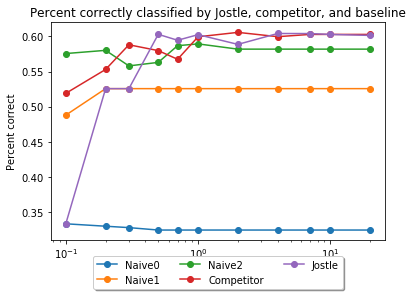

In [191]:
do_linegraph(results_to_dataframe(performance_epsilon_dset, names_arthur, 0))

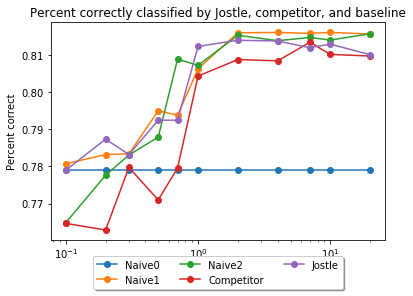

In [192]:
do_linegraph(results_to_dataframe(performance_epsilon_dset, names_arthur, 1))

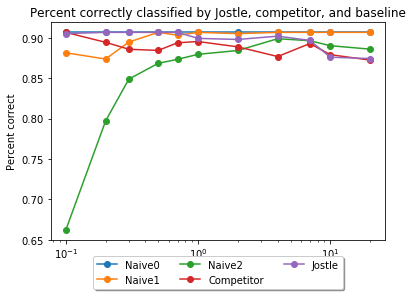

In [193]:
do_linegraph(results_to_dataframe(performance_epsilon_dset, names_arthur, 2))

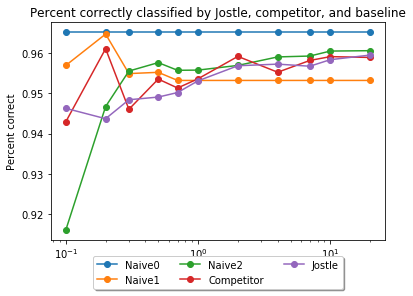

In [194]:
do_linegraph(results_to_dataframe(performance_epsilon_dset, names_arthur, 3))

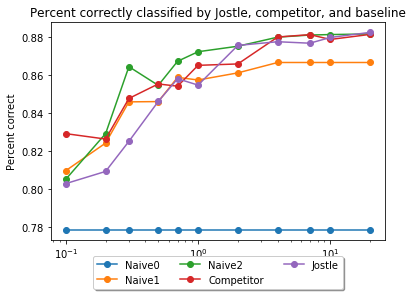

In [195]:
do_linegraph(results_to_dataframe(performance_epsilon_dset, names_arthur, 4))

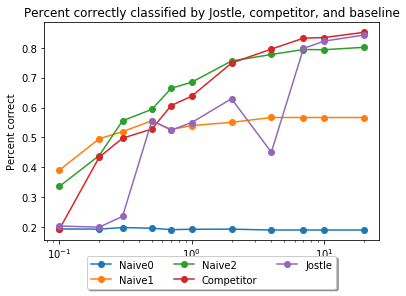

In [196]:
do_linegraph(results_to_dataframe(performance_epsilon_dset, names_arthur, 5))

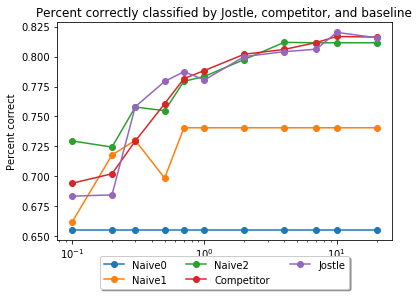

In [197]:
do_linegraph(results_to_dataframe(performance_epsilon_dset, names_arthur, 6))

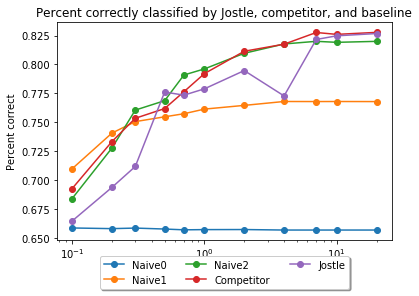

In [198]:
#Average over every dataset
do_linegraph(results_to_dataframe(performance_epsilon_dset, names_arthur))